<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Basic_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The motivation behind this notebook comes from [Sebastian Rachka](https://sebastianraschka.com/) who constantly inspires me through his work in the field of deep learning. Quite a few days, he open-sourced his repo [deeplearning-models](https://github.com/rasbt/deeplearning-models) which contains implementations of a wide variety of deep learning models. I started with [this notebook](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-basic.ipynb) which shows a very simplistic and minimal implementation of a fully-connected _autoencoder_.

In [0]:
!pip install tensorflow-gpu==2.0.0-beta0

In [0]:
# Imports
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
np.random.seed(7)

print(tf.__version__)

2.0.0-beta0


In [0]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


In [0]:
# Define the constants
NUM_FEATURES = 784
UNITS = 32

In [0]:
# Custom class for a simple FC autoencoder
class AutoEncoder(tf.keras.Model):
  
  def __init__(self, num_features, units):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.layers.Dense(units, activation='linear', 
                                         input_shape=(num_features,),
                                         kernel_initializer='glorot_normal',
                                         bias_initializer='zeros')
    self.decoder = tf.keras.layers.Dense(num_features, activation='linear', input_shape=(units,))
    self.leaky_relu = tf.keras.layers.LeakyReLU(0.5)
  
  def call(self, x):
    encoded = self.encoder(x)
    encoded = self.leaky_relu(encoded)
    decoded = tf.sigmoid(self.decoder(encoded))
    return decoded

# Instantiate the autoencoder
auto_encoder = AutoEncoder(NUM_FEATURES, UNITS)

In [0]:
# Define loss function and optimizer
loss_func = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [0]:
# Flatten the training images
X_train_copy = X_train.copy()

X_train_copy = X_train_copy.reshape(60000, 28*28).astype(np.float32)

print(X_train_copy.shape)

(60000, 784)


In [0]:
# Batches of 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train_copy, y_train)).batch(64)

In [0]:
# Average out the loss after each epoch
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [0]:
# Train the model
@tf.function
def model_train(features):
    # Define the GradientTape context
    with tf.GradientTape() as tape:
        # Get the probabilities
        decoded = auto_encoder(features)
        # Calculate the loss
        loss = loss_func(decoded, features)
    # Get the gradients
    gradients = tape.gradient(loss, auto_encoder.trainable_variables)
    # Update the weights
    optimizer.apply_gradients(zip(gradients, auto_encoder.trainable_variables))

    train_loss(loss)
    return decoded

In [0]:
# Begin training
decode_list = []
for epoch in range(20):
  for features, _ in train_ds:
    features = features
    decoded = model_train(features)
  
  template = 'Epoch {}, loss: {}'
  print (template.format(epoch+1,
                         train_loss.result()))

Epoch 1, loss: 1.649407982826233
Epoch 2, loss: 1.3055578470230103
Epoch 3, loss: 1.1296701431274414
Epoch 4, loss: 1.0245317220687866
Epoch 5, loss: 0.9548731446266174
Epoch 6, loss: 0.9051530957221985
Epoch 7, loss: 0.866610586643219
Epoch 8, loss: 0.8354974389076233
Epoch 9, loss: 0.8103290796279907
Epoch 10, loss: 0.7897171378135681
Epoch 11, loss: 0.7726050019264221
Epoch 12, loss: 0.7579894065856934
Epoch 13, loss: 0.7453299760818481
Epoch 14, loss: 0.7341734170913696
Epoch 15, loss: 0.7243269085884094
Epoch 16, loss: 0.715560793876648
Epoch 17, loss: 0.7077820897102356
Epoch 18, loss: 0.700776994228363
Epoch 19, loss: 0.6943405866622925
Epoch 20, loss: 0.6884656548500061


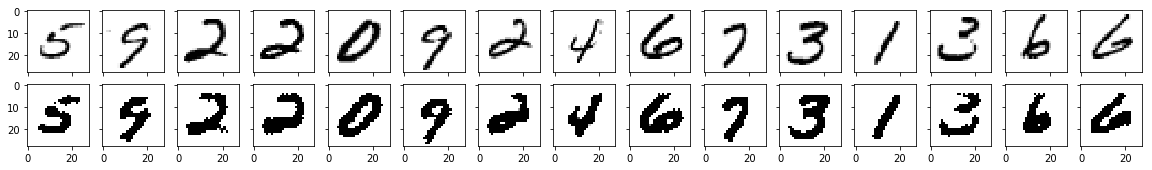

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images].numpy()
decoded_images = decoded[:n_images].numpy()

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i]
        ax[i].imshow(curr_img.reshape((image_width, image_width)), cmap='binary')